In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Input, Dropout
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import f1_score
from keras.regularizers import l2
np.random.seed(7)

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
MAX_SEQUENCE_LENGTH = 15
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 300

In [3]:
data = pd.read_csv("bitcoin_data.csv")
test_data = pd.read_csv("data.csv", low_memory=False)

In [4]:
data.head()

,Timestamp,Username,Label,Tweet,URL
0,"March 14, 2018 at 09:47PM",@RizkyF_404,spam,RT @kickcity_io: Token Kart added KickCity to ...,http://twitter.com/RizkyF_404/status/973903509...
1,"March 14, 2018 at 09:47PM",@exchangebutler,spam,RT @Denaro_io: Our support team is here to hel...,http://twitter.com/exchangebutler/status/97390...
2,"March 14, 2018 at 09:47PM",@Bilalbinsaqib,pos,$eth trendline broke\nnext support @600 and th...,http://twitter.com/Bilalbinsaqib/status/973903...
3,"March 14, 2018 at 09:47PM",@ahsen_soydan,spam,RT @ahsen_soydanvip: 💎 High Quality Partner ✔️...,http://twitter.com/ahsen_soydan/status/9739035...
4,"March 14, 2018 at 09:47PM",@mourneopened,hype,RT @izx_io: IZETEX is on the Battle of the Cry...,http://twitter.com/mourneopened/status/9739035...


In [5]:
test_data.head()

,Unnamed: 0,Link,TImestamp,Timestamp,Tweet,User
0,0,http://twitter.com/pehlivanhakki/status/903407...,"September 01, 2017 at 12:00AM",NaN,RT @maxkeiser: Just $200 away from $5k. #Bitco...,@pehlivanhakki
1,1,http://twitter.com/torisamadotcom/status/90340...,"September 01, 2017 at 12:00AM",NaN,RT @missbitcoin_mai: 昨日はドイツのメディア🇩🇪日本のメディア🇯🇵最後は...,@torisamadotcom
2,2,http://twitter.com/dignetdesigns/status/903407...,"September 01, 2017 at 12:00AM",NaN,RT @AAlNaggar: What is a #Bitcoin and how does...,@dignetdesigns
3,3,http://twitter.com/coins24by7/status/903407191...,"September 01, 2017 at 12:00AM",NaN,"#bitcoin Price: $4,735.04 Chg: 3.08% Vol: $333...",@coins24by7
4,4,http://twitter.com/aguptaindia/status/90340719...,"September 01, 2017 at 12:00AM",NaN,RT @CryptoNewswire: Top 6 BTC/USD Exchange Ord...,@aguptaindia


In [6]:
data = pd.DataFrame.dropna(data)
data = pd.DataFrame.drop_duplicates(data)

In [7]:
data = data[data.Label != 'neutral']

In [8]:
# Match test data to training data
test_data['URL'] = test_data['Link']
test_data['Username'] = test_data['User']
test_data['Timestamp'] = test_data['Timestamp'].fillna('')
test_data['TImestamp'] = test_data['TImestamp'].fillna('')
test_data['Timestamp'] = test_data['TImestamp'].map(str) + test_data['Timestamp']
test_data = test_data.drop(columns=['TImestamp', 'Link', 'User'])

In [9]:
test_data

,Unnamed: 0,Timestamp,Tweet,URL,Username
0,0,"September 01, 2017 at 12:00AM",RT @maxkeiser: Just $200 away from $5k. #Bitco...,http://twitter.com/pehlivanhakki/status/903407...,@pehlivanhakki
1,1,"September 01, 2017 at 12:00AM",RT @missbitcoin_mai: 昨日はドイツのメディア🇩🇪日本のメディア🇯🇵最後は...,http://twitter.com/torisamadotcom/status/90340...,@torisamadotcom
2,2,"September 01, 2017 at 12:00AM",RT @AAlNaggar: What is a #Bitcoin and how does...,http://twitter.com/dignetdesigns/status/903407...,@dignetdesigns
3,3,"September 01, 2017 at 12:00AM","#bitcoin Price: $4,735.04 Chg: 3.08% Vol: $333...",http://twitter.com/coins24by7/status/903407191...,@coins24by7
4,4,"September 01, 2017 at 12:00AM",RT @CryptoNewswire: Top 6 BTC/USD Exchange Ord...,http://twitter.com/aguptaindia/status/90340719...,@aguptaindia
5,5,"September 01, 2017 at 12:00AM",Join the casino club at https://t.co/ZSV6pMtlX...,http://twitter.com/betbybitcoins/status/903407...,@betbybitcoins
6,6,"September 01, 2017 at 12:00AM",#Bitcoin $4704.98 (d.+3.08%) #BTC\n#Ethereum $...,http://twitter.com/BitcoinRater/status/9034072...,@BitcoinRater
7,7,"September 01, 2017 at 12:00AM",RT @golangnews: Building a blockchain in go #b...,http://twitter.com/cool_golang/status/90340722...,@cool_golang
8,8,"September 01, 2017 at 12:07AM",RT @HashRushGame: The last chance to participa...,http://twitter.com/EvgPerevozchiko/status/9034...,@EvgPerevozchiko
9,9,"September 01, 2017 at 12:07AM",RT @WhalePanda: I never had any #Bitcoin to be...,http://twitter.com/Mr_CryptoRobot/status/90340...,@Mr_CryptoRobot


## Multi-class classification system with 5 classes

In [10]:
print(len(data.Label.unique()))
print(len(data))

5
1338


Label
doom     62
hype    177
neg      91
pos     211
spam    797
dtype: int64


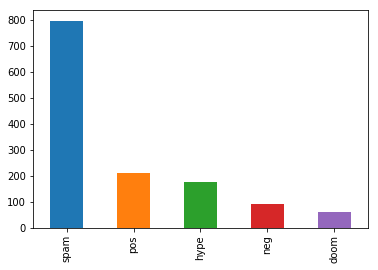

In [11]:
print(data.groupby('Label').size())
%matplotlib inline
import matplotlib as plt
data['Label'].value_counts().plot(kind="bar")

In [12]:
texts = data["Tweet"].values
test_texts = test_data["Tweet"].values
labels = data["Label"].values

## Cleaning tweets

In [13]:
# stemming + stopword_removal

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def stemming_stopword_removal(texts):
    text = []
    for i in range(0, len(texts)):
        tweet = re.sub('[^a-zA-Z\s+]','', texts[i])
        tweet = re.sub(r'http\S+', '', texts[i]).lower().split()
        tweet = [word for word in tweet if not word in set(stopwords.words('english'))]
        tweet = ' '.join(tweet)
        text.append(tweet)
    text = np.asarray(text)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnlau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
text = stemming_stopword_removal(texts)
text.shape

(1338,)

In [15]:
test_text = stemming_stopword_removal(test_texts)
test_text.shape

(134239,)

In [16]:
combined_text = np.concatenate((text, test_text), axis=None)
combined_text.shape

(135577,)

In [17]:
# tokenizing and sequencing
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
# Combine training and test texts to ensure all tokens available to prevent prediction error
tokenizer.fit_on_texts(combined_text)
sequences = tokenizer.texts_to_sequences(text)
test_sequences = tokenizer.texts_to_sequences(test_text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 71124 unique tokens.


In [18]:
df = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_df = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [19]:
print('Training data frame shape', df.shape)
print('Test data frame shape', test_df.shape)

Training data frame shape (1338, 15)
Test data frame shape (134239, 15)


In [20]:
target_names = data.Label.unique() # list of label ids
target_dict = {n:i for i, n in enumerate(target_names)} # list of label names
labels = data.Label.map(target_dict)
labels = to_categorical(np.asarray(labels))

In [21]:
target_dict

{'spam': 0, 'pos': 1, 'hype': 2, 'neg': 3, 'doom': 4}

In [22]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (1338, 5)
Shape of label tensor: (1338, 5)


In [23]:
# Shuffle the training data frame
indices = np.arange(df.shape[0])
np.random.shuffle(indices)
data = df[indices]
labels = labels[indices]

In [24]:
X = data
y = labels

In [25]:
# split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

## Pre-training on Glove embeddings

In [26]:
# embedding matrx
embeddings_index = {}
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# embedding matrix
count = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[index] = embedding_vector
    else:
        count += 1
print(count) 


# embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) 

Found 400000 word vectors.
47764


In [27]:
# build model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.3)))
model.add(Dropout(0.3))
model.add(Dense(len(target_names), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['acc'])

In [28]:
model.fit(X_train, y_train,
          batch_size=32,
          epochs=4, validation_data=(X_test, y_test))

Train on 1070 samples, validate on 268 samples
Epoch 1/4
1070/1070 [==============================] - 18s 17ms/step - loss: 1.1114 - acc: 0.5757 - val_loss: 1.0417 - val_acc: 0.6194
Epoch 2/4
1070/1070 [==============================] - 15s 14ms/step - loss: 0.7992 - acc: 0.7103 - val_loss: 1.1374 - val_acc: 0.6045
Epoch 3/4
1070/1070 [==============================] - 16s 15ms/step - loss: 0.5444 - acc: 0.8056 - val_loss: 1.2281 - val_acc: 0.6007
Epoch 4/4
1070/1070 [==============================] - 16s 15ms/step - loss: 0.3210 - acc: 0.9000 - val_loss: 1.4417 - val_acc: 0.6045


In [29]:
y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_pred_class, digits=3))

             precision    recall  f1-score   support

          0      0.738     0.887     0.806       159
          1      0.279     0.267     0.273        45
          2      0.261     0.200     0.226        30
          3      0.143     0.062     0.087        16
          4      0.500     0.111     0.182        18

avg / total      0.556     0.604     0.567       268



In [30]:
target_dict

{'spam': 0, 'pos': 1, 'hype': 2, 'neg': 3, 'doom': 4}

In [31]:
test_prediction = model.predict(test_df)

In [32]:
test_prediction

array([[4.29726392e-01, 4.23425913e-01, 1.19695827e-01, 1.54645741e-02,
        1.16871912e-02],
       [7.39767611e-01, 1.46735504e-01, 6.84868321e-02, 2.73146201e-02,
        1.76953934e-02],
       [3.35899740e-02, 5.61883897e-02, 3.68558206e-02, 5.87127805e-01,
        2.86238015e-01],
       ...,
       [7.25558475e-02, 9.55858678e-02, 7.68347263e-01, 1.01487525e-02,
        5.33622727e-02],
       [9.47682083e-01, 3.69272605e-02, 1.34508759e-02, 1.24926458e-03,
        6.90587156e-04],
       [7.42556453e-01, 1.82386532e-01, 6.97669014e-02, 2.78643006e-03,
        2.50371406e-03]], dtype=float32)

In [35]:
# Get the index of the maximum value by each row
predicted_class = np.argmax(test_prediction, axis=1)
predicted_class.shape

(134239,)

In [88]:
import datetime

NUM_TO_PLOT = 200
predicted_datetime = []

# String to datetime object. Timezone follows the machine which in this case JST
for str_dt in test_data[:NUM_TO_PLOT]['Timestamp']:
    dt = datetime.datetime.strptime(str_dt, '%B %d, %Y at %I:%M%p')
    predicted_datetime.append(dt.timestamp())

min_predicted_datetime = min(predicted_datetime)
max_predicted_datetime = max(predicted_datetime)
print('Minimum timestamp', min_predicted_datetime, datetime.datetime.fromtimestamp(min_predicted_datetime).isoformat())
print('Maximum timestamp', max_predicted_datetime, datetime.datetime.fromtimestamp(max_predicted_datetime).isoformat())

Minimum timestamp 1504191600.0 2017-09-01T00:00:00
Maximum timestamp 1504196940.0 2017-09-01T01:29:00


In [89]:
from poloniex import Poloniex

polo = Poloniex()

# Minimum period is 5 minutes (300 secs)
polo_data = polo.returnChartData('USDT_BTC', period=300, start=min_predicted_datetime, end=max_predicted_datetime)

btc_datetime = []
btc_prices = []
for polo_row in polo_data:
    btc_avg_price = (float(polo_row['high']) + float(polo_row['low'])) / 2.0
    btc_prices.append(btc_avg_price)
    btc_datetime.append(polo_row['date'])

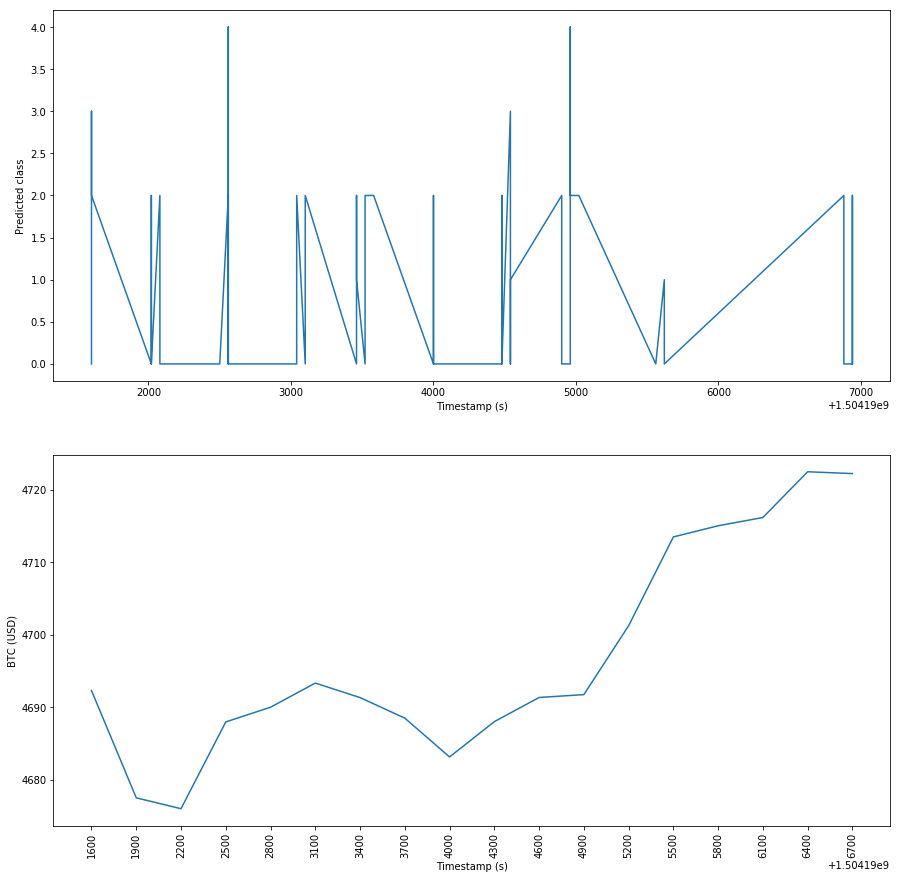

In [105]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15,15)) # Set to a larger size than usual
plt.subplot(211)

# Plot x by array index to be able to see everything
# However label each x value with its corresponding timestamp
# x = np.arange(NUM_TO_PLOT) 
# plt.xticks(x, predicted_datetime, rotation='vertical', size='x-small')

x = predicted_datetime
y = predicted_class[:NUM_TO_PLOT]
plt.plot(x, y)
plt.ylabel('Predicted class')
plt.xlabel('Timestamp (s)')

plt.subplot(212)
x_btc = btc_datetime
y_btc = btc_prices
plt.plot(x_btc, y_btc)
plt.ylabel('BTC (USD)')
plt.xlabel('Timestamp (s)')
plt.xticks(x_btc, rotation='vertical')

plt.subplots_adjust(hspace=0.2)

plt.show()